This notebook illustrates the bias-variance trade-off and double descent in a linear regression model.  Double descent means that test (out-of-sample) error can sometimes be reduced by adding more parameters to the model, contrary to the traditional bias-variance U curves that argued for a "sweet spot" at a fewer number of parameters.  Originally, double descent was only believed to exist for deep neural nets, but a paper by Dar et al. found it in linear regression.  But is it real in linear regression or a statistical artifact?  Read more below.

# Libraries

In [1]:
import numpy as np
import pandas as pd
import warnings

import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

# Data set

Here I load a data set to analyze.  In an earlier R version of this notebook, I used the "mtcars" data set which has data on various models in Motor Trend cars of the year.

The goal is to predict the miles per gallon (mpg) of various models based on their other characteristics.

In [2]:
import os
notebook_path = os.path.abspath("double_descent_mtcars_reg.ipynb")
print(notebook_path)
csv_path = os.path.join(os.path.dirname(notebook_path), "data/mt_cars.csv")
print(csv_path)

/Users/jeanortega/PycharmProjects/pythonProject1/double_descent_mtcars_reg.ipynb
/Users/jeanortega/PycharmProjects/pythonProject1/data/mt_cars.csv


In [3]:
df = pd.read_csv(csv_path)

In [4]:
df

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
5,Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
6,Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
7,Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
8,Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
9,Merc 280,19.2,6,167.6,123,3.92,3.440,18.30,1,0,4,4


# Split X and y

Here we put the data in a standard format for analysis.  If you load your own data set, you will need to tweak the target column and remove the non-numeric columns-- or code them, e.g. with one-hot encoding.

In [5]:
TARGET_COL = "mpg"

In [6]:
NON_NUMERIC_COLS = ["model"]

In [7]:
y = df[TARGET_COL]
X = df.drop([TARGET_COL] + NON_NUMERIC_COLS,axis=1)

# Functions

In [8]:
random_state = 10 # For reproducibility
num_sampled_rows = 4
num_sampled_columns = 5

In [9]:
indices = np.random.choice(df.index, num_sampled_rows, replace=False)

In [10]:
# X_subset = X.sample(n=num_sampled_rows, random_state=random_state, axis=0)
X_subset = X.iloc[indices]
y_subset = y.iloc[indices]

In [11]:
X_subset = X_subset.sample(n=num_sampled_columns, random_state=random_state, axis=1)

In [12]:
X_subset

,gear,hp,qsec,vs,drat
7,4,62,20.00,1,3.69
30,5,335,14.60,0,3.54
17,4,66,19.47,1,4.08
18,4,52,18.52,1,4.93


In [13]:
y_subset

7     24.4
30    15.0
17    32.4
18    30.4
Name: mpg, dtype: float64

# Using the package

I have a little package to help sample a dataframe in a way that makes it easy to create conditions for the underfitting, interpolation, and overfitting regime.

In [14]:
# The simplest way to make this reproducible.
np.random.seed(0)

In [15]:
from double_descent_dar import sample_eval

In [16]:
random_state = None # Set for reproducibility
num_sampled_rows = 3
num_sampled_columns = 4

In [17]:
X_train, X_test, y_train, y_test = sample_eval.train_test_split_by_rows_and_cols(X, y, num_train_rows=num_sampled_rows, num_columns=num_sampled_columns, replace=False, random_state=random_state, verbose=True)

using train_size 0.09375


In [18]:
X_train

,hp,gear,wt,carb
6,245,3,3.57,4
23,245,3,3.84,4
4,175,3,3.44,2


In [19]:
y_train

6     14.3
23    13.3
4     18.7
Name: mpg, dtype: float64

What we will do is fit a linear regression on this data and then measure out of sample error.


In [20]:
# model = RandomForestRegressor()
# model = linear_model.Ridge(alpha=.5)
model = linear_model.LinearRegression(fit_intercept=True)

In [21]:
model.fit(X_train, y_train)

LinearRegression()

In [22]:
# my_metric = root_mean_squared_error
my_metric = mean_absolute_error

In [23]:
train_error = my_metric(y_train, model.predict(X_train))
train_error

np.float64(0.0)

In [24]:
test_error = my_metric(y_test, model.predict(X_test))
test_error

np.float64(2.7667122936628337)

As expected, train error (in-sample fit) is lower than test error (out of sample).

We will do this again and again and look at the average metric value for combinations of number of rows and columns.

# Bias-variance U curve

Seeing a traditional bias-variance U curve requires that the number of parameters should be a lot less than the number of rows.  Since the data set has 9 columns, we will need a lot more rows. This section will sample 15 rows (out of a total of 32) to train on.

We will sample between 2 and 8 columns (out of a total of 10 numeric columns) to see how the error metric varies by the number of parameters.

Note that the regression used here includes an intercept, so 8 columns + 1 intercept -> 9 parameters.  With 15 rows to train on, full interpolation would be reached with 15 columns.

In [25]:
X.shape

(32, 10)

In [26]:
num_train_rows = 15
num_sampled_columns = 3

In [27]:
X_train, X_test, y_train, y_test = sample_eval.train_test_split_by_rows_and_cols(X, y, num_train_rows=num_train_rows, num_columns=num_sampled_columns, replace=False, random_state=random_state, verbose=True)
X_train

using train_size 0.46875


,disp,gear,carb
18,75.7,4,2
1,160.0,4,4
10,167.6,4,4
9,167.6,4,4
29,145.0,5,6
15,460.0,3,4
17,78.7,4,1
20,120.1,3,1
8,140.8,4,2
6,360.0,3,4


In [28]:
def sample_by_num_cols(num_sampled_columns_local):
    return sample_eval.sample_and_calc_metric_by_rows_and_cols(X, y, num_train_rows=num_train_rows, num_columns=num_sampled_columns_local, model=model, metric_func=my_metric, replace=False, random_state=random_state)['test']

In [29]:
num_samples = 1000
metric_all_samples = []
for num_sampled_columns in range(1, X.shape[1]-1):
    metric_all_samples.append((num_sampled_columns, [sample_by_num_cols(num_sampled_columns) for _ in range(num_samples)]))

In [30]:
for key, values in metric_all_samples:
    the_mean = np.mean(values)
    the_stdev = np.std(values)
    print(f'num_cols: {key}, mean error: {the_mean:9.3f}, stdev of error: {the_stdev:4.1f}')

num_cols: 1, mean error:     3.699, stdev of error:  0.9
num_cols: 2, mean error:     3.134, stdev of error:  0.8
num_cols: 3, mean error:     2.877, stdev of error:  0.6
num_cols: 4, mean error:     2.773, stdev of error:  0.6
num_cols: 5, mean error:     2.900, stdev of error:  0.7
num_cols: 6, mean error:     3.081, stdev of error:  0.9
num_cols: 7, mean error:     3.376, stdev of error:  1.3
num_cols: 8, mean error:     3.784, stdev of error:  1.6


In [31]:
metric_means = [(col_val_tuple[0], np.mean(col_val_tuple[1])) for col_val_tuple in metric_all_samples]

In [32]:
res = list(zip(*metric_means))
num_cols = res[0]
means = res[1]

In [33]:
my_metric.__name__

'mean_absolute_error'

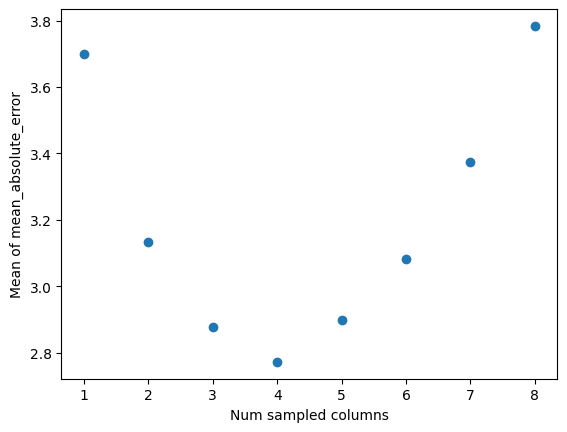

In [34]:
plt.scatter(num_cols, means)
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.show()

That is a beautiful U shape.  The linear regression's lowest average test (out-of-sample) error was achieved at 4 columns, which with the intercept means 5 parameters to fit.  This is much less than the 9 columns available in the data set.

(There is no simple theory that predicts what the optimal number of parameters will be.) 

## Double descent

A paper by Dar et al. (), called "Farewell to Bias Variance?" showed mathematically that double descent could be exhibited by linear regression under certain conditions. 

The paper: 
Yehuda Dar, Muthukumar, V., & Baraniuk, R. (2021). A Farewell to the Bias-Variance Tradeoff? An Overview of the Theory of Overparameterized Machine Learning. https://arxiv.org/abs/2109.02355


Here I show double descent empirically on the mtcars data set (widely used by R users).

Seeing double descent requires that the number of parameters should be a lot MORE than the number of rows. Since the data set has only 9 columns, we achieve this with a trick-- sampling fewer rows.

This section will train on 7 rows (out of a total of 32).

As before, will sample between 2 and 8 columns (out of a total of 9 columns) to see how the error metric varies by the number of parameters.  

The linear regression model will be able to fully interpolate the data at 7 columns because it is fit to 7 rows.

In [35]:
num_train_rows = 7

In [36]:
def sample_by_num_cols(num_sampled_columns_local):
    return sample_eval.sample_and_calc_metric_by_rows_and_cols(X, y, num_train_rows=num_train_rows, num_columns=num_sampled_columns_local, model=model, metric_func=my_metric, replace=False, random_state=random_state)['test']

In [37]:
num_samples = 200
train_proportion = 0.5
metric_all_samples = []
for num_sampled_columns in range(1, X.shape[1]-1):
    metric_all_samples.append((num_sampled_columns, [sample_by_num_cols(num_sampled_columns) for _ in range(num_samples)]))

In [38]:
metric_means = [(col_val_tuple[0], np.mean(col_val_tuple[1])) for col_val_tuple in metric_all_samples]

In [39]:
res = list(zip(*metric_means))
num_cols = res[0]
means = res[1]

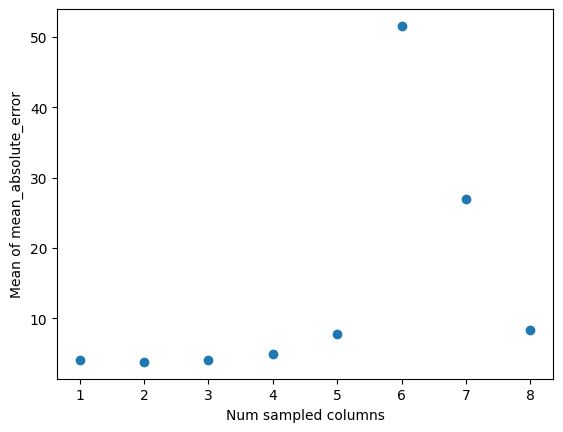

In [40]:
plt.scatter(num_cols, means)
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.show()

As predicted, there was a spike in test (out of sample) error followed by a descent in error after the spike.  However, the spike was at 6 not 7 columns.  The spike is because the fitting method is highly unstable near full interpolation.

The key lesson: Error descends a second time after the spike, so we observe classic double descent.  Double descent was formerly thought to be a weird feature of fitting neural nets, but here we observe it with simple, traditional linear regression.

# Double descent is actually two U curves in linear regression

A recent paper pointed out that different fitting methods are used on different sides of the interpolation threshold in linear regression.  When the number of rows N > number of paramters p, the best estimator involves inverting the N x p matrix.  But a matrix with more columns than rows cannot be inverted, so other parameter estimation methods are required.  The paper argues that it is this change in estimation methods that produces the two humps.  Each estimation method on its own has a U-shaped bias-variance curve, and the so-called double descent shape is just blending these two U's.

The paper:
Curth, A., Jeffares, A., & Schaar, M. van der. (2023, November 2). A U-turn on Double Descent: Rethinking Parameter Counting in Statistical Learning. Thirty-seventh Conference on Neural Information Processing Systems. https://openreview.net/forum?id=O0Lz8XZT2b


# Double descent in linear regression is real

Here I address that point by using a version of linear regression that uses the same estimation method on both sides of the interpolation threshold-- stochastic gradient descent (SGD), the same method used by neural nets.  The Curth et al argument only applies to cases where two different estimation methods are used, but gradient descent can apply to all shapes of the data matrix.

Notes:
* The SGDRegressor assumes input has been scaled from 0 to 1, so I wrap it inside a pipeline to handle scaling.
* By default the SGDRegressor includes regularization, so to make it comparable to the pure LinearRegression example above, I have to set the penalty to None.

In [41]:
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
model = make_pipeline(StandardScaler(), SGDRegressor(random_state=0, penalty=None))

In [42]:
num_train_rows = 15
def sample_by_num_cols(num_sampled_columns_local):
    return sample_eval.sample_and_calc_metric_by_rows_and_cols(X, y, num_train_rows=num_train_rows, num_columns=num_sampled_columns_local, model=model, metric_func=my_metric, replace=False, random_state=random_state)['test']

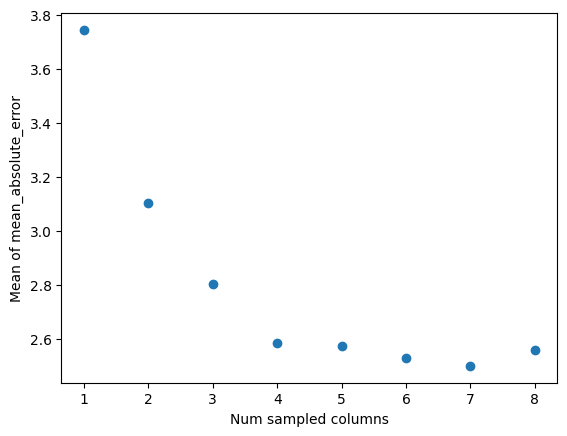

In [43]:
num_samples = 300
metric_all_samples = []
# This example won't converge because we have such a small data sst
# so we catch the warning and ignore it here.
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    for num_sampled_columns in range(1, X.shape[1]-1):
        metric_all_samples.append((num_sampled_columns, [sample_by_num_cols(num_sampled_columns) for _ in range(num_samples)]))
metric_means = [(col_val_tuple[0], np.mean(col_val_tuple[1])) for col_val_tuple in metric_all_samples]
res = list(zip(*metric_means))
num_cols = res[0]
means = res[1]
plt.scatter(num_cols, means)
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.show()

Nice!  This is the "left" half of a U curve.  It minimizes test (out-of-sample) error with 7 columns.

In [44]:
# Lower rows to see if we get double descent.
# The interpolation threshold is at 7 columns.
num_train_rows = 7
def sample_by_num_cols(num_sampled_columns_local):
    return sample_eval.sample_and_calc_metric_by_rows_and_cols(X, y, num_train_rows=num_train_rows, num_columns=num_sampled_columns_local, model=model, metric_func=my_metric, replace=False, random_state=random_state)['test']

In [ ]:
num_samples = 300
train_proportion = 0.5
metric_all_samples = []
# This example won't converge because we have such a small data sst
# so we catch the warning and ignore it here.
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    for num_sampled_columns in range(1, X.shape[1]-1):
        metric_all_samples.append((num_sampled_columns, [sample_by_num_cols(num_sampled_columns) for _ in range(num_samples)]))
metric_means = [(col_val_tuple[0], np.mean(col_val_tuple[1])) for col_val_tuple in metric_all_samples]
res = list(zip(*metric_means))
num_cols = res[0]
means = res[1]
plt.scatter(num_cols, means)
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.show()

The bump up at 7 columns fits the prediction.

Let me squeeze harder by lowering the number of rows even more.  Fitting on 5 rows means the interpolation threshold will be at 5 columns.

In [ ]:
# Lower rows to see if we get double descent.
num_train_rows = 5
def sample_by_num_cols(num_sampled_columns_local):
    return sample_eval.sample_and_calc_metric_by_rows_and_cols(X, y, num_train_rows=num_train_rows, num_columns=num_sampled_columns_local, model=model, metric_func=my_metric, replace=False, random_state=random_state)['test']

In [ ]:
num_samples = 500
metric_all_samples = []
# This example won't converge because we have such a small data sst
# so we catch the warning and ignore it here.
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    for num_sampled_columns in range(1, X.shape[1]-1):
        metric_all_samples.append((num_sampled_columns, [sample_by_num_cols(num_sampled_columns) for _ in range(num_samples)]))
metric_means = [(col_val_tuple[0], np.mean(col_val_tuple[1])) for col_val_tuple in metric_all_samples]
res = list(zip(*metric_means))
num_cols = res[0]
means = res[1]
plt.scatter(num_cols, means)
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.show()

That does look double descent-ish except that the bump up is at 7 columns, not 5.  We should have seen the bump move to fewer columns as we reduce the number of rows.

I need to study the SGDRegressor-- not to mention the possible effect of the StandardScaler-- to understand the number of parameters estimated so I can predict and explain exactly when and where the bump up happens.

## Conclusion

Based on the shapes above, using a consistent estimation method, I argue that **double descent is real** and not merely the overlap of two U curves from two different estimation methods.

# Appendix: Fun with an MLPRegressor

Now consider a simple one-layer, feed-forward neural net (MLP = multi-layer perceptron) that is fit with stochastic gradient descent.

Warning: the activation function makes it non-linear.

In [ ]:
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# TODO: scale hidden layer neurons to number of columns.
model = make_pipeline(
    StandardScaler(), 
    MLPRegressor(hidden_layer_sizes=(4,), validation_fraction=0, solver="sgd", random_state=0))

In [ ]:
# First just look for the bias-variance U curve
num_train_rows = 15

In [ ]:
def sample_by_num_cols(num_sampled_columns_local):
    return sample_eval.sample_and_calc_metric_by_rows_and_cols(X, y, num_train_rows=num_train_rows, num_columns=num_sampled_columns_local, model=model, metric_func=my_metric, replace=False, random_state=random_state)['test']

In [ ]:
num_samples = 400
metric_all_samples = []
# This example won't converge because we have such a small data sst
# so we catch the warning and ignore it here.
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    for num_sampled_columns in range(1, X.shape[1]-1):
        metric_all_samples.append((num_sampled_columns, [sample_by_num_cols(num_sampled_columns) for _ in range(num_samples)]))
metric_means = [(col_val_tuple[0], np.mean(col_val_tuple[1])) for col_val_tuple in metric_all_samples]
res = list(zip(*metric_means))
num_cols = res[0]
means = res[1]
plt.scatter(num_cols, means)
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.show()

This looks pretty U-shaped.

In [ ]:
# Lower the number of rows to look for double descent.
num_train_rows = 5

In [ ]:
num_samples = 500
metric_all_samples = []
# This example won't converge because we have such a small data sst
# so we catch the warning and ignore it here.
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    for num_sampled_columns in range(1, X.shape[1]-1):
        metric_all_samples.append((num_sampled_columns, [sample_by_num_cols(num_sampled_columns) for _ in range(num_samples)]))
metric_means = [(col_val_tuple[0], np.mean(col_val_tuple[1])) for col_val_tuple in metric_all_samples]
res = list(zip(*metric_means))
num_cols = res[0]
means = res[1]
plt.scatter(num_cols, means)
plt.xlabel("Num sampled columns")
plt.ylabel("Mean of " + my_metric.__name__)
plt.show()

I'm not sure what pattern I'm seeing.  But to do this in an apples-to-apples way with the prior regression studies, the number of hidden layer neurons should correspond to the number of sampled columns (because a weight is estimated for each neuron, and we want the number of parameters to scale, not just number of inputs).  Or maybe something else?  I'm still working on this one.